#934G5: Machine Learning
# CandNo: 244106


In [ ]:
!pip install 'aif360[LFR]'

In [2]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2022-05-13 11:26:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.3’

adult.data.3        100%[===================>]   3.79M  3.13MB/s    in 1.2s    

2022-05-13 11:26:56 (3.13 MB/s) - ‘adult.data.3’ saved [3974305/3974305]

--2022-05-13 11:26:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names.3’

adult.names.3       100%[===================>]   5.11K  --.-KB/s    in 0s      


In [4]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc

--2022-05-13 11:26:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data.3’

german.data.3       100%[===================>]  77.92K   260KB/s    in 0.3s    

2022-05-13 11:27:00 (260 KB/s) - ‘german.data.3’ saved [79793/79793]

--2022-05-13 11:27:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4679 (4.6K) [application/x-httpd-php]
Saving to: ‘german.doc.3’

german.doc.3        100%[===================>]   4.57K  --.-KB/s    i

## For some reason you need to run the following cell twice:

In [7]:
# NOTE: import (run cell) twice

import numpy as np
import matplotlib.pyplot as plt

# AIF360 imports
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german

from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

# Scaler for normalisation
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import *

# models
from sklearn.linear_model import LogisticRegression

np.random.seed(0) 

#Adult

##Step 1. Prepare the dataset

In [8]:
# label the sensitive feature to be investigated
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

# load in the dataset
dataset_orig = load_preproc_data_adult(['sex'])

# split training and test data
train, test = dataset_orig.split([0.7], shuffle=True)

# normalise dataset
ss = StandardScaler()
# try actually normalising the whole 'train' and 'test' dataset objects
train.features = ss.fit_transform(train.features)
X_train = train.features
y_train = train.labels.ravel()
test.features = ss.transform(test.features) 
X_test = test.features
y_test = test.labels.ravel()

# Viktoriia's method: does not actually change the train or test objects...
#X_train = ss.fit_transform(train.features)
#y_train = train.labels.ravel()
#X_test = ss.transform(test.features) 
#y_test = test.labels.ravel()

In [9]:
# functions to get folds and to perform 5-fold cross-validation

def get_folds(X):

  # split into 5 folds 
  kf = KFold(n_splits=5)
  kf.get_n_splits(X)

  # return the indices of all 5 splits
  fold_indices = kf.split(X)

  # iterate through and put into dictionary
  folds = {}
  for i, (train_index, test_index) in enumerate(fold_indices):
    folds[i] = (train_index, test_index)

  return folds

def perform_cross_fold_accuracy(folds, X, y, reg_strength, train_weights=None, reweighed = False):
  """
    only pass in X_train and y_train into this function as we only want to 
  perform cross validation on the training set.
  """
  accuracies = []

  # loop through dictionary and get accuracy score for each fold
  for fold_num, indices in folds.items():
    X_train, X_test = X[indices[0]], X[indices[1]]
    y_train, y_test = y[indices[0]], y[indices[1]]

    # if train_weights not equal to None, then get relevant subset
    if reweighed == False:
      sample_weights = None
    else:
      sample_weights = train_weights[indices[0]]

    # define and fit classifier on the training data
    clf = LogisticRegression(C=reg_strength, solver='liblinear', random_state=1)  
    clf.fit(X_train,y_train,sample_weight=sample_weights)

    # get predictions 
    pred = clf.predict(X_test)

    # compute the accuracy and append to list
    accuracy = clf.score(X_test, y_test)
    accuracies.append(accuracy)

  # return the mean and standard deviation of accuracies for all 5 folds
  return np.mean(accuracies), np.std(accuracies)

In [10]:
# create folds dict
folds = get_folds(X_train)

###Step 2. C parameter sweep for accuracy

In [11]:
def parameter_sweep_accuracy(c_s, reweighed=False):

  accs = []
  stds = []

  # loop through C values and perform 5-fold cross validation on training dataset
  for c_value in c_s:
    if reweighed:
      acc, std = perform_cross_fold_accuracy(folds, X_train, y_train, reg_strength=c_value, train_weights=train.instance_weights, reweighed=True)
    else:
      acc, std = perform_cross_fold_accuracy(folds, X_train, y_train, reg_strength=c_value)

    accs.append(acc)
    stds.append(std)

  return accs, stds

In [12]:
# provide a list of possible regularisation values
c_values = np.logspace(-15, 15, num=50)
#c_values = np.logspace(-6, 1, num=50)

# perform hyperparameter sweep over reg strengths
accs1, stds1 = parameter_sweep_accuracy(c_values)

In [13]:
# graph of regularisation strength versus accuracy

def plot_graph(c_s, metric, standard_deviations, metric_name, dataset):
  # plot accuracy against log of regularisation strength
  plt.plot(np.log10(c_s), metric)
  plt.errorbar(np.log10(c_s), metric, yerr = standard_deviations, fmt='.', ecolor = 'cyan', color='black')
  plt.title(f'Effect of regularisation strength on {metric_name}: {dataset}')
  # C is the inverse of regularization strength
  plt.xlabel(" $Log_{10}$(C)")
  if metric_name == 'accuracy':
    plt.ylabel("Accuracy")
  if metric_name == 'fairness':
    plt.ylabel("Equality of Opportunity")
  if metric_name == 'both':
    plt.ylabel('Z')    
  plt.show()

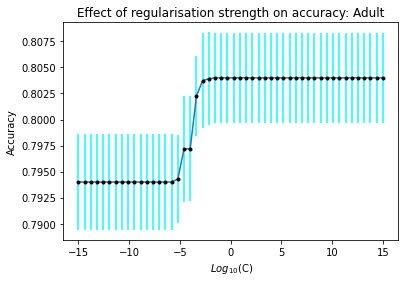

In [14]:
plot_graph(c_values, accs1, stds1, 'accuracy', 'Adult')

In [15]:
# find the most accurate
def find_accuracy_c_value(accuracies, c_s):
  print(f'The maximum accuracy achieved during 5-fold cross-val is {max(accuracies)}')
  index = accuracies.index(max(accuracies))
  print(f'The index of this highest score is {index}')
  best_for_accuracy = c_s[index]
  print(f'Therefore, the best C value is {best_for_accuracy}')
  return best_for_accuracy

In [16]:
best_for_ac1 = find_accuracy_c_value(accs1, c_values)

The maximum accuracy achieved during 5-fold cross-val is 0.804001308538186
The index of this highest score is 22
Therefore, the best C value is 0.029470517025518096


In [17]:
# Using above C-value, train and test the selected (accurate) model

def test_final_model_accuracy(best_for_accuracy, X_train, y_train, X_test, y_test, reweighed=False):
  # only fit Classifier on the training data
  clf = LogisticRegression(C=best_for_accuracy, solver='liblinear', random_state=1)  
  if reweighed:
    clf.fit(X_train,y_train, sample_weight=train.instance_weights)
  else:
    clf.fit(X_train,y_train)
  # get predictions 
  pred = clf.predict(X_test)
  # compute the accuracy
  accuracy = clf.score(X_test, y_test)
  print(f'The final accuracy for this model is {accuracy}')
  return accuracy

best_accuracy = test_final_model_accuracy(best_for_ac1, X_train, y_train, X_test, y_test)

The final accuracy for this model is 0.8042039172865625


In [82]:
#best_accuracy = test_final_model_accuracy(6.25E-06, X_train, y_train, X_test, y_test,reweighed=False)

The final accuracy for this model is 0.64


##Step 3. Fairness parameter sweep

In [18]:
def perform_cross_fold_fairness(folds, training_data, reg_strength, train_weights=None, reweighed=False): 
  """ 
    only pass in X_train and y_train into this function as we only want to 
  perform cross validation on the training 
  """

  eq_ops = []

  # first convert into a subset object
  iterable_data = training_data.copy()

  # loop through fold dictionary and train and test
  for fold_num, indices in folds.items():

    train, test = iterable_data.subset(indices[0]), iterable_data.subset(indices[1])

    X_train = train.features
    y_train = train.labels.ravel()
    X_test = test.features
    y_test = test.labels.ravel() 
    #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )

    # define classifier
    clf = LogisticRegression(C=reg_strength, solver='liblinear', random_state=1)  

    # get training reweights if relevant
    if reweighed == False:
      sample_weights = None
    else:
      sample_weights = train_weights[indices[0]]

    # train classifier on training data
    clf.fit(X_train, y_train, sample_weight=sample_weights)

    # get predictions 
    pred = clf.predict(X_test)

    # compute equality of opportunity (fairness) metric
    test_pred = test.copy()
    test_pred.labels = pred

    metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    eq_op = metric.equal_opportunity_difference()

    # append to list
    eq_ops.append(eq_op)
  
  # return the mean and standard deviation of the fairness metrics
  return np.mean(eq_ops), np.std(eq_ops)

In [19]:
def parameter_sweep_fairness(c_s, reweighed=False):

  eq_ops = []
  stds = []

  # loop through C values and perform 5-fold cross validation on training dataset
  for c_value in c_s:
    if reweighed:
      eq_op, std = perform_cross_fold_fairness(folds, train, reg_strength=c_value, train_weights=train.instance_weights, reweighed=True)
    else:
      eq_op, std = perform_cross_fold_fairness(folds, train, reg_strength=c_value)

    eq_ops.append(eq_op)
    stds.append(std)

  return eq_ops, stds  

In [20]:
# perform hyperparameter sweep
eq_ops1, stds_fair1 = parameter_sweep_fairness(c_values)

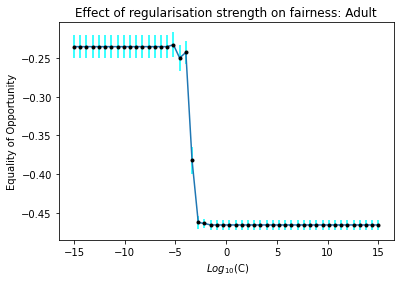

In [21]:
plot_graph(c_values, eq_ops1, stds_fair1, 'fairness', 'Adult')

In [22]:
def find_fairness_c_value(equality_of_ops, c_s):
  index1 = equality_of_ops.index(min(equality_of_ops, key=abs))
  print(min(equality_of_ops, key=abs))
  print(f'The index of this best score is {index1}')
  best_cs = c_s[index1]
  print(f'Therefore, the best C value is {best_cs}')
  return best_cs

# get the best model
best_for_fair1 = find_fairness_c_value(eq_ops1, c_values)
print(best_for_fair1)

-0.2324529173619491
The index of this best score is 16
Therefore, the best C value is 6.250551925273976e-06
6.250551925273976e-06


In [23]:
# Using above C-value, train and test the selected (fair) model

def test_final_model_fairness(best_fair, test, X_train, y_train, X_test, y_test, reweighed=False):
  # only fit Classifier on the training data
  clf = LogisticRegression(C=best_fair, solver='liblinear', random_state=1)  
  if reweighed:
    clf.fit(X_train,y_train, sample_weight=train.instance_weights)
  else:
    clf.fit(X_train,y_train)
  # get predictions 
  pred = clf.predict(X_test)
  # compute equality of opportunity (fairness) metric
  test_pred = test.copy()
  test_pred.labels = pred
  metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
  eq_op = metric.equal_opportunity_difference()
  print(f'The final equality of opportunity value for this model is {eq_op}')

  return eq_op

In [24]:
final_fairness = test_final_model_fairness(best_for_fair1, test, X_train, y_train, X_test, y_test)

The final equality of opportunity value for this model is -0.24153321836248665


In [83]:
#final_fairness = test_final_model_fairness(0.029470517025518096, test, X_train, y_train, X_test, y_test)

The final equality of opportunity value for this model is -0.4632554945054945


##Step 4. Reweigh the data


In [25]:
# transforming the dataset by reweighing.
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# this gives us instance weights
train = RW.fit_transform(train)

# 4 groups: male 50k+, female 50k+, male < 50k, female < 50k
print("subgroup weights", np.unique(train.instance_weights)) 

subgroup weights [0.78875735 0.85514075 1.09270553 2.1493453 ]


##Step 5. Accuracy parameter sweep: Reweighed

In [26]:
# Rewighed!
accs2, stds2 = parameter_sweep_accuracy(c_values, reweighed=True)


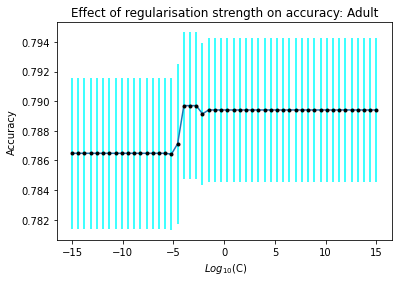

In [27]:
plot_graph(c_values, accs2, stds2, 'accuracy', 'Adult')

In [28]:
best_for_ac2 = find_accuracy_c_value(accs2, c_values)

The maximum accuracy achieved during 5-fold cross-val is 0.7896985173023461
The index of this highest score is 18
Therefore, the best C value is 0.00010481131341546875


In [29]:
best_accuracy2 = test_final_model_accuracy(best_for_ac2, X_train, y_train, X_test, y_test,reweighed=True)

The final accuracy for this model is 0.7905548351873336


In [85]:
#best_accuracy2 = test_final_model_accuracy(2.559547922699533e-05, X_train, y_train, X_test, y_test,reweighed=True)

The final accuracy for this model is 0.6366666666666667


##Step 6. Fairness parameter sweep: Reweighed

In [30]:
eq_ops2, stds_fair2 = parameter_sweep_fairness(c_values, reweighed=True)

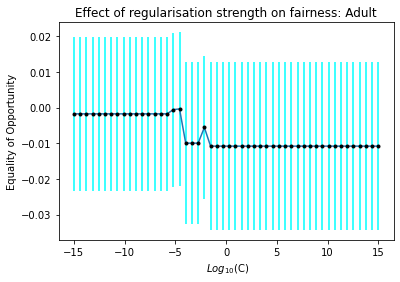

In [31]:
plot_graph(c_values, eq_ops2, stds_fair2, 'fairness', 'Adult')

In [32]:
best_for_fair2 = find_fairness_c_value(eq_ops2, c_values)

-0.00035721253218468085
The index of this best score is 17
Therefore, the best C value is 2.559547922699533e-05


In [33]:
final_fairness2 = test_final_model_fairness(best_for_fair2, test, X_train, y_train, X_test, y_test,reweighed=True)

The final equality of opportunity value for this model is 0.035579370945224564


In [84]:
#final_fairness2 = test_final_model_fairness(0.00010481131341546875, test, X_train, y_train, X_test, y_test,reweighed=True)

The final equality of opportunity value for this model is -0.15521978021978022


#GERMAN

##Step 1. Prepare the dataset

In [34]:
# label the sensitive feature to be investigated
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

# load in the dataset
dataset_orig = load_preproc_data_german(['age'])

# split training and test data
train, test = dataset_orig.split([0.7], shuffle=True)

# normalise dataset
ss = StandardScaler()
# try actually normalising the whole 'train' and 'test' dataset objects
train.features = ss.fit_transform(train.features)
X_train = train.features
y_train = train.labels.ravel()
test.features = ss.transform(test.features) 
X_test = test.features
y_test = test.labels.ravel()

In [35]:
# create folds dict
folds = get_folds(X_train)

##Step 2. Accuracy parameter sweep

In [36]:
# perform hyperparameter sweep over reg strengths
accs1_G, stds1_G = parameter_sweep_accuracy(c_values)

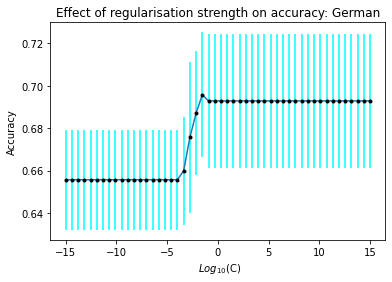

In [37]:
plot_graph(c_values, accs1_G, stds1_G, 'accuracy', 'German')

In [38]:
best_for_ac1_G = find_accuracy_c_value(accs1_G, c_values)
best_accuracy1_G = test_final_model_accuracy(best_for_ac1_G, X_train, y_train, X_test, y_test)

The maximum accuracy achieved during 5-fold cross-val is 0.6957142857142857
The index of this highest score is 22
Therefore, the best C value is 0.029470517025518096
The final accuracy for this model is 0.7033333333333334


In [86]:
#best_accuracy1_G = test_final_model_accuracy(0.029470517025518096, X_train, y_train, X_test, y_test)

The final accuracy for this model is 0.7033333333333334


##Step 3. Fairness parameter sweep 


In [39]:
# perform hyperparameter sweep
eq_ops1_G, stds_fair1_G = parameter_sweep_fairness(c_values)

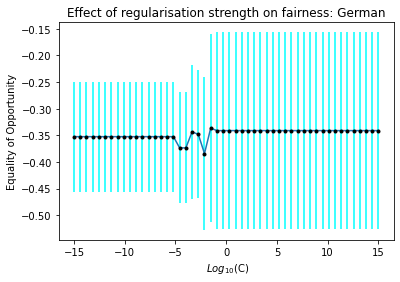

In [40]:
plot_graph(c_values, eq_ops1_G, stds_fair1_G, 'fairness', 'German')

In [41]:
best_for_fair1_G = find_fairness_c_value(eq_ops1_G, c_values)
final_fairness1_G = test_final_model_fairness(best_for_fair1_G, test, X_train, y_train, X_test, y_test)

-0.33646940627430644
The index of this best score is 22
Therefore, the best C value is 0.029470517025518096
The final equality of opportunity value for this model is -0.4632554945054945


In [87]:
#final_fairness1_G = test_final_model_fairness(0.029470517025518096, test, X_train, y_train, X_test, y_test)

The final equality of opportunity value for this model is -0.4632554945054945


##Step 4. Reweigh

In [42]:
# transforming the dataset by reweighing.
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# this gives us instance weights
train = RW.fit_transform(train)

# 4 groups: male 50k+, female 50k+, male < 50k, female < 50k
print("subgroup weights", np.unique(train.instance_weights)) 

subgroup weights [0.71684729 0.9597479  1.10527473 1.21054945]


##Step 5. Accuracy parameter sweep: reweighed

In [43]:
# Rewighed!
accs2_G, stds2_G = parameter_sweep_accuracy(c_values, reweighed=True)


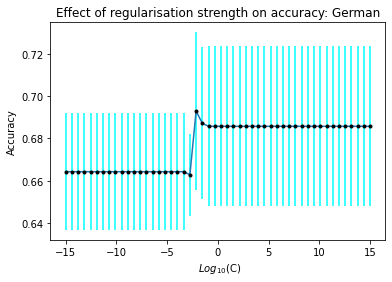

In [44]:
plot_graph(c_values, accs2_G, stds2_G, 'accuracy', 'German')

In [45]:
best_for_ac2_G = find_accuracy_c_value(accs2_G, c_values)
best_accuracy2_G = test_final_model_accuracy(best_for_ac2_G, X_train, y_train, X_test, y_test,reweighed=True)

The maximum accuracy achieved during 5-fold cross-val is 0.6928571428571428
The index of this highest score is 21
Therefore, the best C value is 0.007196856730011528
The final accuracy for this model is 0.68


In [89]:
#best_accuracy2_G = test_final_model_accuracy(0.029470517025518096, X_train, y_train, X_test, y_test,reweighed=True)

The final accuracy for this model is 0.68


##Step 6. Fairness parameter sweep: Reweighed

In [46]:
eq_ops2_G, stds_fair2_G = parameter_sweep_fairness(c_values, reweighed=True)

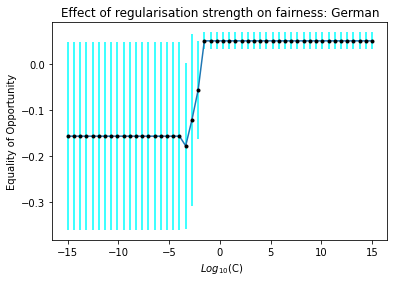

In [47]:
plot_graph(c_values, eq_ops2_G, stds_fair2_G, 'fairness', 'German')

In [48]:
best_for_fair2_G = find_fairness_c_value(eq_ops2_G, c_values)
final_fairness2_G = test_final_model_fairness(best_for_fair2_G, test, X_train, y_train, X_test, y_test,reweighed=True)

0.050281034642801134
The index of this best score is 22
Therefore, the best C value is 0.029470517025518096
The final equality of opportunity value for this model is 0.08241758241758246


In [88]:
#final_fairness2_G = test_final_model_fairness(0.007196856730011528, test, X_train, y_train, X_test, y_test,reweighed=True)

The final equality of opportunity value for this model is 0.08241758241758246


# Plot German and Adult together

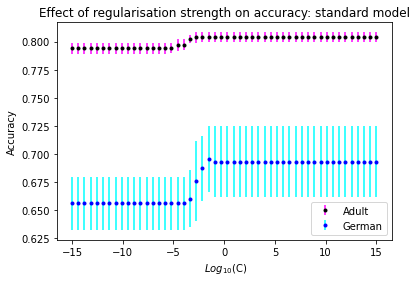

In [49]:
# plot adult
#plt.scatter(np.log10(c_values), accs1, label='Adult' )
plt.errorbar(np.log10(c_values), accs1, yerr = stds1, fmt='.', ecolor = 'magenta', color='black', label='Adult')

#plot german
#plt.scatter(np.log10(c_values), accs1, label='German')
plt.errorbar(np.log10(c_values), accs1_G, yerr = stds1_G, fmt='.', ecolor = 'cyan', color='blue', label='German')

plt.title('Effect of regularisation strength on accuracy: standard model')


# C is the inverse of regularization strength
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()  

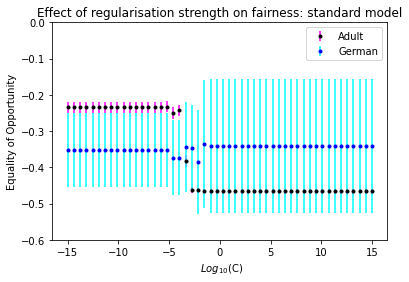

In [50]:
# plot adult
#plt.scatter(np.log10(c_values), accs1, label='Adult' )
plt.errorbar(np.log10(c_values), eq_ops1, yerr = stds_fair1, fmt='.', ecolor = 'magenta', color='black', label='Adult')

#plot german
#plt.scatter(np.log10(c_values), accs1, label='German')
plt.errorbar(np.log10(c_values), eq_ops1_G, yerr = stds_fair1_G, fmt='.', ecolor = 'cyan', color='blue', label='German')

plt.title('Effect of regularisation strength on fairness: standard model')


# C is the inverse of regularization strength
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel("Equality of Opportunity")
plt.ylim(-0.6,0)
plt.legend()
plt.show() 

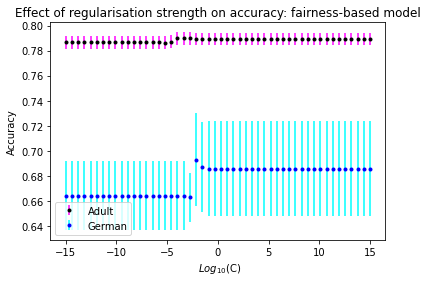

In [51]:
# plot adult
#plt.scatter(np.log10(c_values), accs1, label='Adult' )
plt.errorbar(np.log10(c_values), accs2, yerr = stds2, fmt='.', ecolor = 'magenta', color='black', label='Adult')

#plot german
#plt.scatter(np.log10(c_values), accs1, label='German')
plt.errorbar(np.log10(c_values), accs2_G, yerr = stds2_G, fmt='.', ecolor = 'cyan', color='blue', label='German')

plt.title('Effect of regularisation strength on accuracy: fairness-based model')


# C is the inverse of regularization strength
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel("Accuracy")
plt.legend()
plt.show() 

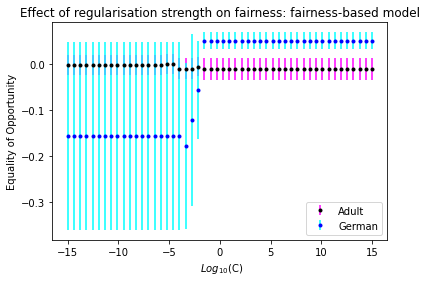

In [52]:
# plot adult
#plt.scatter(np.log10(c_values), accs1, label='Adult' )
plt.errorbar(np.log10(c_values), eq_ops2, yerr = stds_fair2, fmt='.', ecolor = 'magenta', color='black', label='Adult')

#plot german
#plt.scatter(np.log10(c_values), accs1, label='German')
plt.errorbar(np.log10(c_values), eq_ops2_G, yerr = stds_fair2_G, fmt='.', ecolor = 'cyan', color='blue', label='German')

plt.title('Effect of regularisation strength on fairness: fairness-based model')


# C is the inverse of regularization strength
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel("Equality of Opportunity")
plt.legend(loc='lower right')
plt.show() 

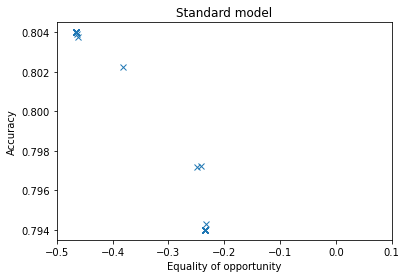

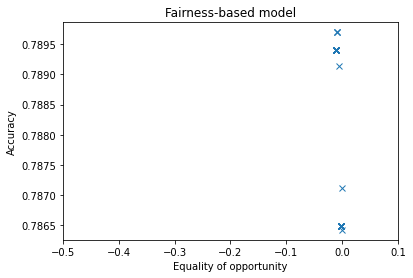

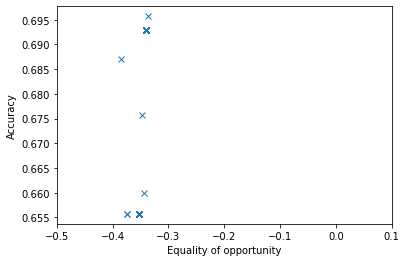

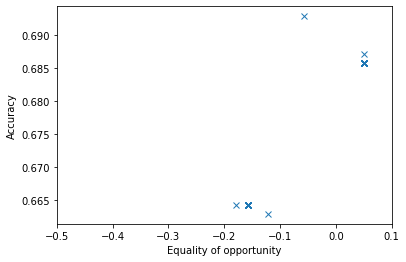

In [53]:
# plot accuracy against fairness for a given c value

plt.plot(eq_ops1, accs1, 'x')
plt.xlim(-0.5, 0.1)
plt.ylabel('Accuracy')
plt.xlabel('Equality of opportunity')
plt.title('Standard model')
plt.show()

plt.plot(eq_ops2, accs2, 'x')
plt.xlim(-0.5, 0.1)
plt.ylabel('Accuracy')
plt.xlabel('Equality of opportunity')
plt.title('Fairness-based model')
plt.show()

plt.plot(eq_ops1_G, accs1_G, 'x')
plt.xlim(-0.5, 0.1)
plt.ylabel('Accuracy')
plt.xlabel('Equality of opportunity')
plt.show()

plt.plot(eq_ops2_G,accs2_G, 'x')
plt.xlim(-0.5, 0.1)
plt.ylabel('Accuracy')
plt.xlabel('Equality of opportunity')
plt.show()


In [54]:
def accurate_fair_combined_NONGLOBAL(accuracies, eq_opportunities):

  # normalise accuracy data
  accs_norm = np.array(accuracies)
  accs_norm = accs_norm - np.amin(accs_norm)
  accs_norm = accs_norm / (np.amax(accs_norm)-np.amin(accs_norm))
  #accs_norm = accs_norm / (np.amax(accs_norm)-0)
  accs_norm = 1 - accs_norm
  
  # normalise fairness data
  eq_ops_norm = np.array(eq_opportunities)
  eq_ops_norm = np.abs(eq_ops_norm)
  eq_ops_norm = eq_ops_norm - np.min(eq_ops_norm)
  eq_ops_norm = eq_ops_norm / (np.max(eq_ops_norm)-np.min(eq_ops_norm))

  fair_and_ac = accs_norm + eq_ops_norm

  # do I normalise the output too?!! How do I make it comparable between datasets / standard vs fair?
  #fair_and_ac = fair_and_ac - np.min(fair_and_ac)
  #fair_and_ac = fair_and_ac / (np.max(fair_and_ac)- np.min(fair_and_ac))

  return fair_and_ac, np.std(fair_and_ac)


In [55]:
def accurate_fair_combined(accuracies, eq_opportunities, accuracies2, eq_opportunities2):

  # find global max range
  accs_norm = np.array(accuracies)
  accs_norm2 = np.array(accuracies2)

  range1 = np.amax(accs_norm)-np.amin(accs_norm)
  range2 = np.amax(accs_norm2)-np.amin(accs_norm2)

  if range1 > range2:
    range = range1
    min1 = np.amin(accs_norm)
  else:
    range = range2
    min1 = np.amin(accs_norm2)

  eq_ops_norm = np.array(eq_opportunities)
  eq_ops_norm2 = np.array(eq_opportunities2)

  erange1 = np.amax(eq_ops_norm)-np.amin(eq_ops_norm)
  erange2 = np.amax(eq_ops_norm2)-np.amin(eq_ops_norm2)

  if erange1 > erange2:
    erange = erange1
    min2 = np.amin(eq_ops_norm)
  else:
    erange = erange2
    min2 = np.amin(eq_ops_norm2)

  # normalise accuracy data
  accs_norm = accs_norm - min1
  accs_norm = accs_norm / range
  accs_norm = 1 - accs_norm
  
  # normalise fairness data
  eq_ops_norm = np.abs(eq_ops_norm)
  eq_ops_norm = eq_ops_norm - min2
  eq_ops_norm = eq_ops_norm / erange

  fair_and_ac = accs_norm + eq_ops_norm

  # do I normalise the output too?!! How do I make it comparable between datasets / standard vs fair?
  #fair_and_ac = fair_and_ac - np.min(fair_and_ac)
  #fair_and_ac = fair_and_ac / (np.max(fair_and_ac)- np.min(fair_and_ac))

  return fair_and_ac, np.std(fair_and_ac)

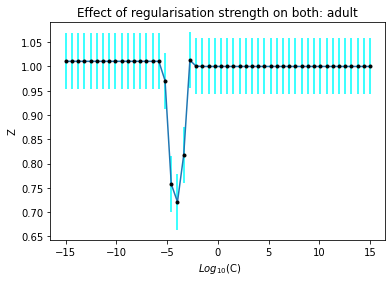

(array([18]),)

In [56]:
fair_and_accurate1, stds_both1 = accurate_fair_combined_NONGLOBAL(accs1, eq_ops1)
plot_graph(c_values, fair_and_accurate1, stds_both1, 'both', 'adult')

np.where(fair_and_accurate1 == np.min(fair_and_accurate1))

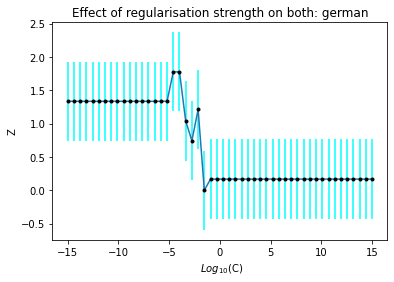

(array([22]),)

In [57]:
fair_and_accurate2, stds_both2 = accurate_fair_combined_NONGLOBAL(accs1_G, eq_ops1_G)
plot_graph(c_values, fair_and_accurate2, stds_both2, 'both', 'german')
np.where(fair_and_accurate2 == np.min(fair_and_accurate2))

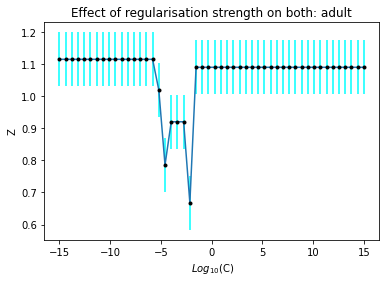

(array([21]),)

In [58]:
fair_and_accurate3, stds_both3 = accurate_fair_combined_NONGLOBAL(accs2, eq_ops2)
plot_graph(c_values, fair_and_accurate3, stds_both3, 'both', 'adult')
np.where(fair_and_accurate3 == np.min(fair_and_accurate3))


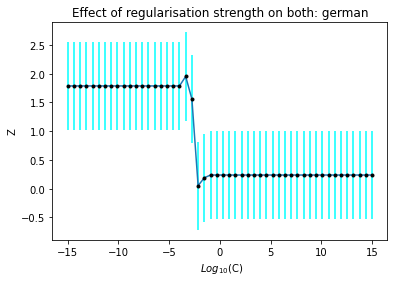

(array([21]),)

In [59]:
fair_and_accurate4, stds_both4 = accurate_fair_combined_NONGLOBAL(accs2_G, eq_ops2_G)
plot_graph(c_values, fair_and_accurate4, stds_both4, 'both', 'german')
np.where(fair_and_accurate4 == np.min(fair_and_accurate4))



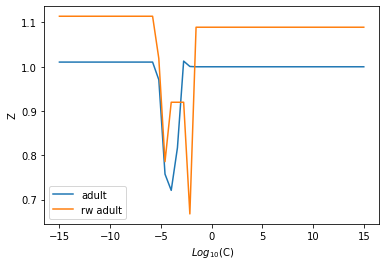

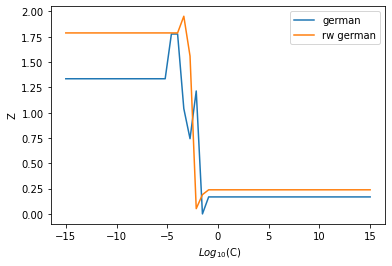

In [60]:
plt.plot(np.log10(c_values), fair_and_accurate1, label='adult')
plt.plot(np.log10(c_values), fair_and_accurate3, label='rw adult')
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel('Z')
plt.legend()
plt.show()


plt.plot(np.log10(c_values), fair_and_accurate2, label='german')
plt.plot(np.log10(c_values), fair_and_accurate4, label='rw german')
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel('Z')
plt.legend()
plt.show()

#plt.plot(np.log10(c_values), fair_and_accurate1, label='adult')
#plt.plot(np.log10(c_values), fair_and_accurate2, label='german')
#plt.legend()
#plt.show()

#plt.plot(np.log10(c_values), fair_and_accurate3, label='rw adult')
#plt.plot(np.log10(c_values), fair_and_accurate4, label='rw german')
#plt.legend()
#plt.show()

In [61]:
print(np.min(fair_and_accurate1))
print(np.min(fair_and_accurate2))
print(np.min(fair_and_accurate3))
print(np.min(fair_and_accurate4))

0.7209350578668351
0.0
0.6677488252347898
0.052228254640853025


In [80]:
print(c_values[18],c_values[22],c_values[21],c_values[21] )

0.00010481131341546875 0.029470517025518096 0.007196856730011528 0.007196856730011528


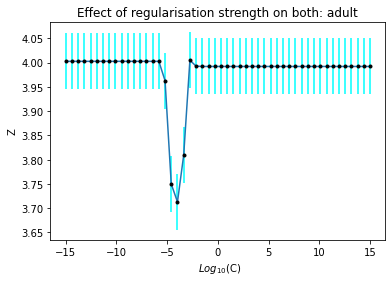

In [62]:
fair_and_accurate1, stds_both1 = accurate_fair_combined(accs1, eq_ops1, accs2, eq_ops2)
plot_graph(c_values, fair_and_accurate1, stds_both1, 'both', 'adult')

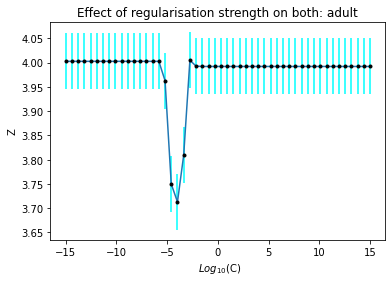

In [63]:
fair_and_accurate2, stds_both2 = accurate_fair_combined(accs1_G, eq_ops1_G, accs2_G, eq_ops2_G)
plot_graph(c_values, fair_and_accurate1, stds_both1, 'both', 'adult')

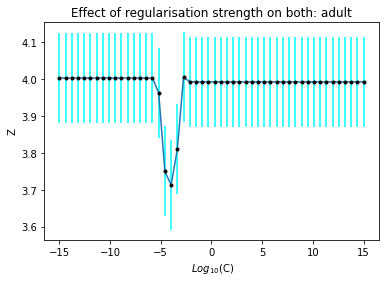

In [64]:
fair_and_accurate3, stds_both1 = accurate_fair_combined(accs2, eq_ops2, accs1, eq_ops1)
plot_graph(c_values, fair_and_accurate1, stds_both1, 'both', 'adult')

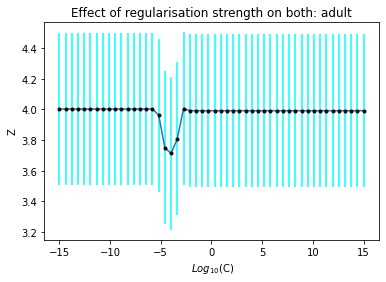

In [65]:
fair_and_accurate4, stds_both1 = accurate_fair_combined(accs2_G, eq_ops2_G, accs1_G, eq_ops1_G)
plot_graph(c_values, fair_and_accurate1, stds_both1, 'both', 'adult')

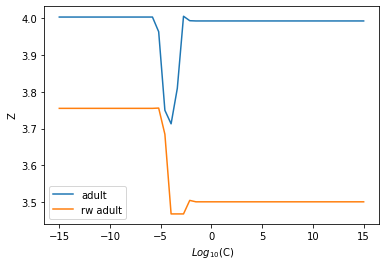

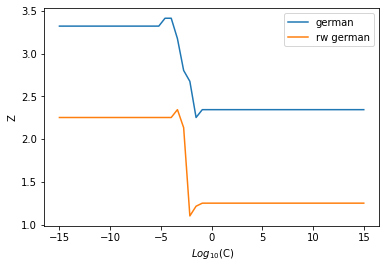

In [66]:
plt.plot(np.log10(c_values), fair_and_accurate1, label='adult')
plt.plot(np.log10(c_values), fair_and_accurate3, label='rw adult')
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel('Z')
plt.legend()
plt.show()


plt.plot(np.log10(c_values), fair_and_accurate2, label='german')
plt.plot(np.log10(c_values), fair_and_accurate4, label='rw german')
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel('Z')
plt.legend()
plt.show()

In [67]:
print(np.min(fair_and_accurate1))
print(np.min(fair_and_accurate2))
print(np.min(fair_and_accurate3))
print(np.min(fair_and_accurate4))

3.7129852060651354
2.253368133495243
3.468551114967607
1.1006547847469057


In [68]:

def get_best(faa):
  best_both = np.amin(faa)
  print(best_both)
  # what is the index of this?
  index_bb = np.where(faa == best_both)
  print(index_bb[0][0])
  print(c_values[index_bb][0])
  return c_values[index_bb]

c1 = get_best(fair_and_accurate1)
c2 = get_best(fair_and_accurate2)
c3 = get_best(fair_and_accurate3)
c4 = get_best(fair_and_accurate4)



3.7129852060651354
18
0.00010481131341546875
2.253368133495243
22
0.029470517025518096
3.468551114967607
18
0.00010481131341546875
1.1006547847469057
21
0.007196856730011528


#Plot normalised accuracy and fairness

In [72]:
# normalise data

accs1_norm = np.array(accs1)
accs1_norm = accs1_norm - np.amin(accs1_norm)
accs1_norm = accs1_norm / (max(accs1)-min(accs1))



eq_ops1_norm = np.array(eq_ops1)
eq_ops1_norm = eq_ops1_norm - np.amin(eq_ops1_norm)
eq_ops1_norm = eq_ops1_norm / (max(eq_ops1)-min(eq_ops1))


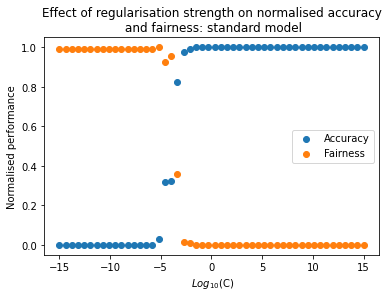

In [73]:
# plot adult
plt.scatter(np.log10(c_values), accs1_norm, label='Accuracy' )
#plt.errorbar(np.log10(c_values), accs1_norm, yerr = stds1, fmt='.', ecolor = 'cyan', color='black', label='Adult')

#plot german
plt.scatter(np.log10(c_values), eq_ops1_norm, label='Fairness')
#plt.errorbar(np.log10(c_values), accs1_G, yerr = stds1_G, fmt='.', ecolor = 'cyan', color='blue', label='German')

plt.title('Effect of regularisation strength on normalised accuracy\n and fairness: standard model')


# C is the inverse of regularization strength
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel("Normalised performance")
plt.legend(loc='best')
plt.show()  

In [74]:
# reweighed

# normalise data

accs2_norm = np.array(accs2)

accs2_norm = accs2_norm - np.amin(accs2_norm)

accs2_norm = accs2_norm / (max(accs2)-min(accs2))



eq_ops2_norm = np.array(eq_ops1)
eq_ops2_norm = eq_ops2_norm - np.amin(eq_ops2_norm)
eq_ops2_norm = eq_ops2_norm / (max(eq_ops2)-min(eq_ops2))

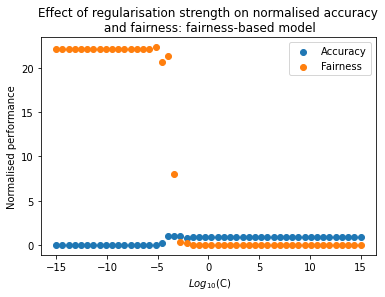

In [75]:
# plot adult
plt.scatter(np.log10(c_values), accs2_norm, label='Accuracy' )
#plt.errorbar(np.log10(c_values), accs1_norm, yerr = stds1, fmt='.', ecolor = 'cyan', color='black', label='Adult')

#plot german
plt.scatter(np.log10(c_values), eq_ops2_norm, label='Fairness')
#plt.errorbar(np.log10(c_values), accs1_G, yerr = stds1_G, fmt='.', ecolor = 'cyan', color='blue', label='German')

plt.title('Effect of regularisation strength on normalised accuracy\n and fairness: fairness-based model')


# C is the inverse of regularization strength
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel("Normalised performance")
plt.legend(loc='best')
plt.show() 

In [76]:
#German dataset

# normalise data

accs1_norm_G = np.array(accs1_G)

accs1_norm_G = accs1_norm_G - np.amin(accs1_norm_G)

accs1_norm_G = accs1_norm_G / (max(accs1_G)-min(accs1_G))



eq_ops1_norm_G = np.array(eq_ops1_G)
eq_ops1_norm_G = eq_ops1_norm_G - np.amin(eq_ops1_norm_G)
eq_ops1_norm_G = eq_ops1_norm_G / (max(eq_ops1_G)-min(eq_ops1_G))


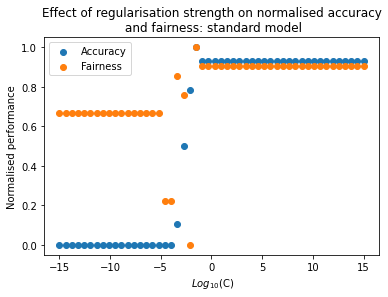

In [77]:
# plot adult
plt.scatter(np.log10(c_values), accs1_norm_G, label='Accuracy' )
#plt.errorbar(np.log10(c_values), accs1_norm, yerr = stds1, fmt='.', ecolor = 'cyan', color='black', label='Adult')

#plot german
plt.scatter(np.log10(c_values), eq_ops1_norm_G, label='Fairness')
#plt.errorbar(np.log10(c_values), accs1_G, yerr = stds1_G, fmt='.', ecolor = 'cyan', color='blue', label='German')

plt.title('Effect of regularisation strength on normalised accuracy\n and fairness: standard model')


# C is the inverse of regularization strength
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel("Normalised performance")
plt.legend(loc='best')
plt.show()  

In [78]:
# normalise data

accs2_norm_G = np.array(accs2_G)

accs2_norm_G = accs2_norm_G - np.amin(accs2_norm_G)

accs2_norm_G = accs2_norm_G / (max(accs2_G)-min(accs2_G))



eq_ops2_norm_G = np.array(eq_ops2_G)
eq_ops2_norm_G = eq_ops2_norm_G - np.amin(eq_ops2_norm_G)
eq_ops2_norm_G = eq_ops2_norm_G / (max(eq_ops2_G)-min(eq_ops2_G))


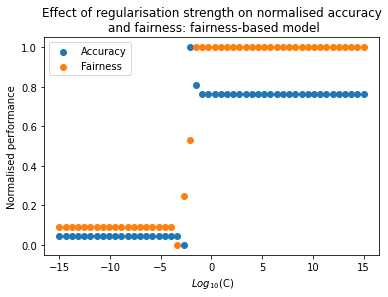

In [79]:
# plot adult
plt.scatter(np.log10(c_values), accs2_norm_G, label='Accuracy' )
#plt.errorbar(np.log10(c_values), accs1_norm, yerr = stds1, fmt='.', ecolor = 'cyan', color='black', label='Adult')

#plot german
plt.scatter(np.log10(c_values), eq_ops2_norm_G, label='Fairness')
#plt.errorbar(np.log10(c_values), accs1_G, yerr = stds1_G, fmt='.', ecolor = 'cyan', color='blue', label='German')

plt.title('Effect of regularisation strength on normalised accuracy\n and fairness: fairness-based model')


# C is the inverse of regularization strength
plt.xlabel(" $Log_{10}$(C)")
plt.ylabel("Normalised performance")
plt.legend(loc='best')
plt.show() 